In [21]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [23]:
X = pd.concat([chunk.sample(frac=0.3) for chunk in chunks])

In [24]:
y=pd.read_csv("../output/reduced_merged.csv.gz",
              compression="gzip",
              index_col=0,
              dtype=np.float32,
              usecols=[0, 1377])

In [25]:
y=y.loc[X.index].values.ravel()

In [26]:
X=X.values

In [27]:
clf = XGBClassifier(base_score=0.005)

In [28]:
clf.fit(X, y)

XGBClassifier(base_score=0.005, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

[ 219  251  266  310  321  369  371  373  374  381  382  383  389  390  420
  440  473  484  487  497  501  504  521  522  539  560  575  608  631  728
  729  746  768  801  802  919 1023 1090 1099 1110 1139 1140 1149 1184 1194
 1196 1199 1200 1226 1234 1235 1236 1245 1246 1251 1259 1262 1274 1291 1292
 1311 1319 1345]


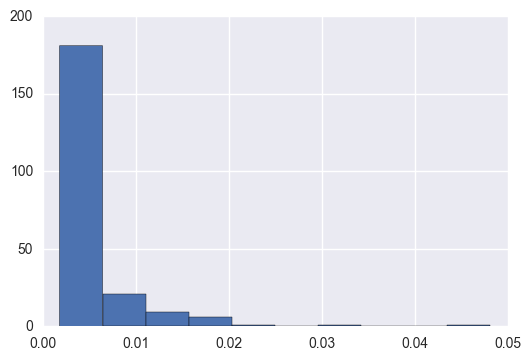

In [29]:
# threshold for a manageable number of features
plt.hist(clf.feature_importances_[clf.feature_importances_>0])
important_indices = np.where(clf.feature_importances_>0.005)[0]
print(important_indices)

In [92]:
X=pd.read_csv("../output/reduced_merged.csv.gz",
              compression="gzip",
              index_col=0,
              dtype=np.float32,
                   usecols=np.concatenate([[0], important_indices+1]))
X=np.concatenate([X], axis=1)

In [93]:
y=pd.read_csv("../output/reduced_merged.csv.gz",
              compression="gzip",
              index_col=0,
              dtype=np.float32,
              usecols=[0, 1377]).values.ravel()

In [94]:
clf = XGBClassifier(max_depth=5, base_score=0.005)
cv = StratifiedKFold(y, n_folds=3)

In [95]:
preds = np.ones(y.shape[0])
for i, (train, test) in enumerate(cv):
    preds[test] = clf.fit(X[train], y[train]).predict_proba(X[test])[:,1]
    print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(y[test], preds[test])))
print(roc_auc_score(y, preds))

fold 0, ROC AUC: 0.720
fold 1, ROC AUC: 0.706
fold 2, ROC AUC: 0.704
0.709675982963


0.252807851525


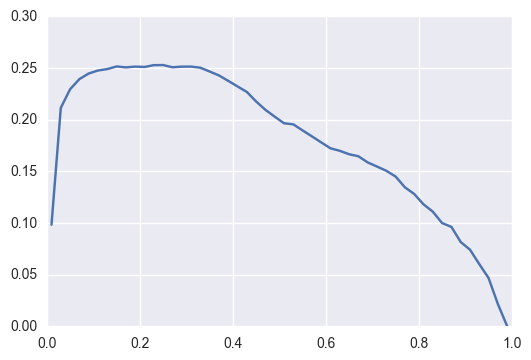

In [96]:
# pick the best threshold out-of-fold
thresholds = np.linspace(0.01, 0.99, 50)
mcc = np.array([matthews_corrcoef(y, preds>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())

In [97]:
X=pd.read_csv("../output/test_reduced_merged.csv.gz",
              compression="gzip",
              index_col=0,
              dtype=np.float32,
                   usecols=np.concatenate([[0], important_indices+1]))
X=np.concatenate([X], axis=1)

In [98]:
# generate predictions at the chosen threshold
preds = (clf.predict_proba(X)[:,1] > best_threshold).astype(np.int8)

In [99]:
# and submit
sub = pd.read_csv("../input/sample_submission.csv", index_col=0)
sub["Response"] = preds
sub.to_csv("submission.csv.gz", compression="gzip")